# 學生表現預測專案

## 專案概述
本專案使用線性回歸模型預測學生的考試成績，採用 CRISP-DM 流程進行資料科學專案開發。

## CRISP-DM 流程
1. **商業理解 (Business Understanding)**
2. **資料理解 (Data Understanding)**
3. **資料準備 (Data Preparation)**
4. **建模 (Modeling)**
5. **評估 (Evaluation)**
6. **部署 (Deployment)**


## 1. 商業理解 (Business Understanding)

### 目標
預測學生的考試成績，幫助教育機構了解影響學生表現的關鍵因素，並提供針對性的改善建議。

### 成功標準
- 建立準確的預測模型（R² > 0.7，RMSE 盡可能低）
- 識別影響學生表現的重要特徵
- 提供可解釋的模型結果


In [1]:
# 導入必要的套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# 設定顯示選項
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# 設定繪圖風格
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 2. 資料理解 (Data Understanding)

### 資料載入與基本資訊


In [2]:
# 載入資料
df = pd.read_csv('student_habits_performance.csv')

# 顯示資料基本資訊
print("資料形狀:", df.shape)
print("\n資料前5筆:")
print(df.head())
print("\n資料欄位資訊:")
print(df.info())
print("\n資料統計摘要:")
print(df.describe())


資料形狀: (1000, 16)

資料前5筆:
  student_id  age  gender  study_hours_per_day  social_media_hours  \
0      S1000   23  Female                  0.0                 1.2   
1      S1001   20  Female                  6.9                 2.8   
2      S1002   21    Male                  1.4                 3.1   
3      S1003   23  Female                  1.0                 3.9   
4      S1004   19  Female                  5.0                 4.4   

   netflix_hours part_time_job  attendance_percentage  sleep_hours  \
0            1.1            No                   85.0          8.0   
1            2.3            No                   97.3          4.6   
2            1.3            No                   94.8          8.0   
3            1.0            No                   71.0          9.2   
4            0.5            No                   90.9          4.9   

  diet_quality  exercise_frequency parental_education_level internet_quality  \
0         Fair                   6                   

In [3]:
# 檢查缺失值
print("缺失值統計:")
print(df.isnull().sum())
print("\n缺失值比例:")
print((df.isnull().sum() / len(df)) * 100)


缺失值統計:
student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64

缺失值比例:
student_id                       0.0
age                              0.0
gender                           0.0
study_hours_per_day              0.0
social_media_hours               0.0
netflix_hours                    0.0
part_time_job                    0.0
attendance_percentage            0.0
sleep_hours                      0.0
diet_quality                     0.0
exercise_frequency        

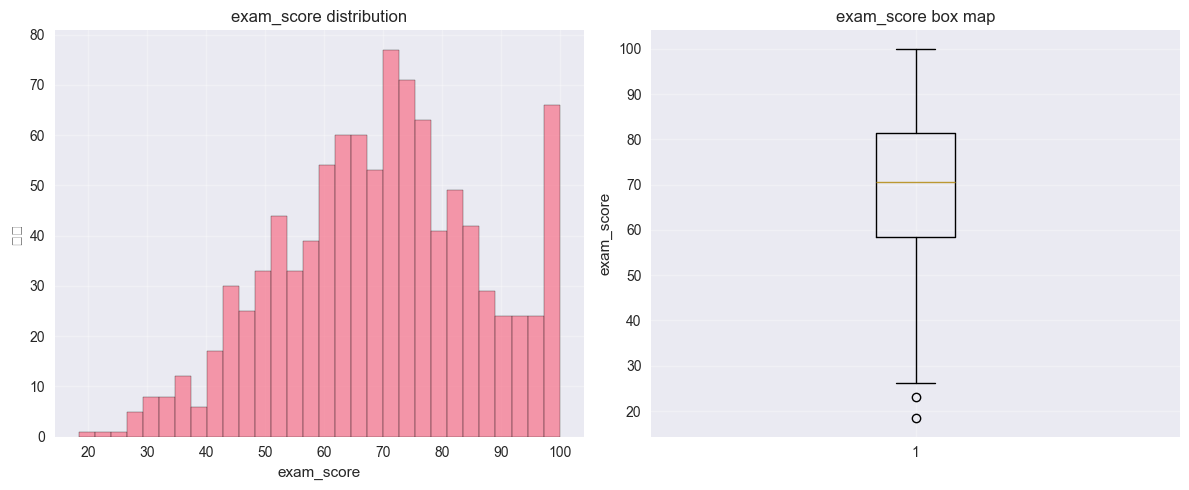

exam_score statistics:
count    1000.000000
mean       69.601500
std        16.888564
min        18.400000
25%        58.475000
50%        70.500000
75%        81.325000
max       100.000000
Name: exam_score, dtype: float64


In [23]:
# 檢查目標變數分佈
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['exam_score'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('exam_score')
plt.ylabel('頻率')
plt.title('exam_score distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(df['exam_score'])
plt.ylabel('exam_score')
plt.title('exam_score box map')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"exam_score statistics:")
print(df['exam_score'].describe())


In [5]:
# 探索類別變數
categorical_cols = ['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 
                    'internet_quality', 'extracurricular_participation']

print("類別變數分佈:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())


類別變數分佈:

gender:
gender
Female    481
Male      477
Other      42
Name: count, dtype: int64

part_time_job:
part_time_job
No     785
Yes    215
Name: count, dtype: int64

diet_quality:
diet_quality
Fair    437
Good    378
Poor    185
Name: count, dtype: int64

parental_education_level:
parental_education_level
High School    392
Bachelor       350
Master         167
Name: count, dtype: int64

internet_quality:
internet_quality
Good       447
Average    391
Poor       162
Name: count, dtype: int64

extracurricular_participation:
extracurricular_participation
No     682
Yes    318
Name: count, dtype: int64


數值變數與考試成績的相關係數:
exam_score               1.000000
study_hours_per_day      0.825419
mental_health_rating     0.321523
exercise_frequency       0.160107
sleep_hours              0.121683
attendance_percentage    0.089836
age                     -0.008907
social_media_hours      -0.166733
netflix_hours           -0.171779
Name: exam_score, dtype: float64


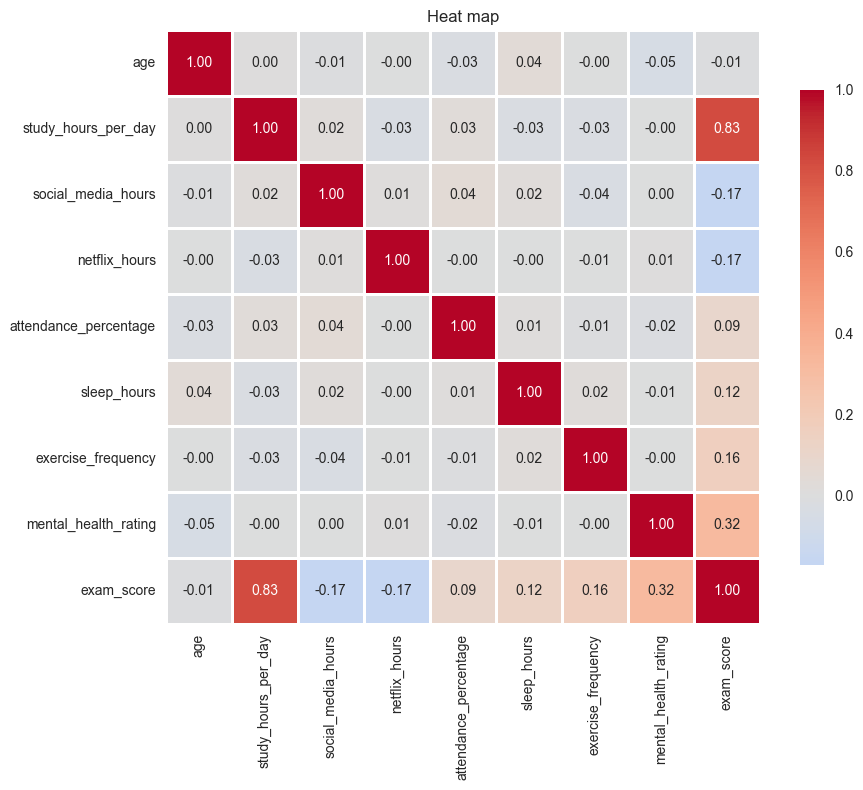

In [7]:
# 探索數值變數與目標變數的相關性
numerical_cols = ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
                  'attendance_percentage', 'sleep_hours', 'exercise_frequency', 'mental_health_rating']

# 計算相關係數
correlation = df[numerical_cols + ['exam_score']].corr()
print("數值變數與考試成績的相關係數:")
print(correlation['exam_score'].sort_values(ascending=False))

# 繪製相關係數熱圖
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Heat map')
plt.tight_layout()
plt.show()


## 3. 資料準備 (Data Preparation)

### 3.1 資料清理


In [8]:
# 建立資料副本
df_clean = df.copy()

# 移除學生ID欄位（第一欄）
df_clean = df_clean.drop('student_id', axis=1)

print("移除學生ID後的資料形狀:", df_clean.shape)
print("\n剩餘欄位:")
print(df_clean.columns.tolist())


移除學生ID後的資料形狀: (1000, 15)

剩餘欄位:
['age', 'gender', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'part_time_job', 'attendance_percentage', 'sleep_hours', 'diet_quality', 'exercise_frequency', 'parental_education_level', 'internet_quality', 'mental_health_rating', 'extracurricular_participation', 'exam_score']


In [9]:
# 分離特徵和目標變數
X = df_clean.drop('exam_score', axis=1)  # 特徵（14個欄位）
y = df_clean['exam_score']  # 目標變數（最後一欄）

print(f"特徵數量: {X.shape[1]}")
print(f"樣本數量: {X.shape[0]}")
print(f"\n特徵名稱:")
print(X.columns.tolist())


特徵數量: 14
樣本數量: 1000

特徵名稱:
['age', 'gender', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'part_time_job', 'attendance_percentage', 'sleep_hours', 'diet_quality', 'exercise_frequency', 'parental_education_level', 'internet_quality', 'mental_health_rating', 'extracurricular_participation']


### 3.2 特徵編碼（處理類別變數）


In [10]:
# 複製特徵資料
X_encoded = X.copy()

# 對類別變數進行編碼
label_encoders = {}

# 二元類別變數（使用 0/1 編碼）
binary_cols = ['gender', 'part_time_job', 'extracurricular_participation']
for col in binary_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"{col} 編碼對應: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 多類別變數（使用獨熱編碼或標籤編碼）
# 對於線性回歸，我們使用標籤編碼（如果類別有順序）或獨熱編碼（如果無順序）
# 這裡使用標籤編碼
multi_cat_cols = ['diet_quality', 'parental_education_level', 'internet_quality']
for col in multi_cat_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"\n{col} 編碼對應: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print(f"\n編碼後的資料形狀: {X_encoded.shape}")
print(f"\n編碼後的資料類型:")
print(X_encoded.dtypes)


gender 編碼對應: {'Female': np.int64(0), 'Male': np.int64(1), 'Other': np.int64(2)}
part_time_job 編碼對應: {'No': np.int64(0), 'Yes': np.int64(1)}
extracurricular_participation 編碼對應: {'No': np.int64(0), 'Yes': np.int64(1)}

diet_quality 編碼對應: {'Fair': np.int64(0), 'Good': np.int64(1), 'Poor': np.int64(2)}

parental_education_level 編碼對應: {'Bachelor': np.int64(0), 'High School': np.int64(1), 'Master': np.int64(2), nan: np.int64(3)}

internet_quality 編碼對應: {'Average': np.int64(0), 'Good': np.int64(1), 'Poor': np.int64(2)}

編碼後的資料形狀: (1000, 14)

編碼後的資料類型:
age                                int64
gender                             int64
study_hours_per_day              float64
social_media_hours               float64
netflix_hours                    float64
part_time_job                      int64
attendance_percentage            float64
sleep_hours                      float64
diet_quality                       int64
exercise_frequency                 int64
parental_education_level           int6

### 3.3 特徵選擇

我們將使用多種方法進行特徵選擇，找出最重要的特徵。


In [11]:
# 方法1: 使用相關係數進行特徵選擇
correlation_scores = X_encoded.corrwith(y).abs().sort_values(ascending=False)
print("特徵與目標變數的相關係數（絕對值）:")
print(correlation_scores)

# 選擇相關係數較高的特徵（例如：前10個）
top_corr_features = correlation_scores.head(10).index.tolist()
print(f"\n相關係數方法選擇的前10個特徵: {top_corr_features}")


特徵與目標變數的相關係數（絕對值）:
study_hours_per_day              0.825419
mental_health_rating             0.321523
netflix_hours                    0.171779
social_media_hours               0.166733
exercise_frequency               0.160107
sleep_hours                      0.121683
attendance_percentage            0.089836
diet_quality                     0.050275
internet_quality                 0.032560
part_time_job                    0.026608
parental_education_level         0.025821
age                              0.008907
gender                           0.002406
extracurricular_participation    0.000881
dtype: float64

相關係數方法選擇的前10個特徵: ['study_hours_per_day', 'mental_health_rating', 'netflix_hours', 'social_media_hours', 'exercise_frequency', 'sleep_hours', 'attendance_percentage', 'diet_quality', 'internet_quality', 'part_time_job']


In [12]:
# 方法2: 使用 SelectKBest (F-test) 進行特徵選擇
selector_f = SelectKBest(score_func=f_regression, k=10)
X_f_selected = selector_f.fit_transform(X_encoded, y)

# 獲取選中的特徵名稱
selected_features_f = X_encoded.columns[selector_f.get_support()].tolist()
feature_scores_f = selector_f.scores_

print("SelectKBest (F-test) 特徵分數:")
feature_importance_f = pd.DataFrame({
    '特徵': X_encoded.columns,
    '分數': feature_scores_f
}).sort_values('分數', ascending=False)
print(feature_importance_f)

print(f"\nSelectKBest 方法選擇的前10個特徵: {selected_features_f}")


SelectKBest (F-test) 特徵分數:
                               特徵           分數
2             study_hours_per_day  2133.626029
12           mental_health_rating   115.065351
4                   netflix_hours    30.344499
3              social_media_hours    28.537596
9              exercise_frequency    26.256193
7                     sleep_hours    14.999206
6           attendance_percentage     8.119825
8                    diet_quality     2.528956
11               internet_quality     1.059165
5                   part_time_job     0.707095
10       parental_education_level     0.665809
0                             age     0.079180
1                          gender     0.005778
13  extracurricular_participation     0.000774

SelectKBest 方法選擇的前10個特徵: ['study_hours_per_day', 'social_media_hours', 'netflix_hours', 'part_time_job', 'attendance_percentage', 'sleep_hours', 'diet_quality', 'exercise_frequency', 'internet_quality', 'mental_health_rating']


In [13]:
# 方法3: 使用遞迴特徵消除 (RFE) 進行特徵選擇
lr_temp = LinearRegression()
rfe = RFE(estimator=lr_temp, n_features_to_select=10)
X_rfe_selected = rfe.fit_transform(X_encoded, y)

# 獲取選中的特徵名稱
selected_features_rfe = X_encoded.columns[rfe.get_support()].tolist()
feature_ranking_rfe = rfe.ranking_

print("RFE 特徵排名 (1表示被選中):")
feature_importance_rfe = pd.DataFrame({
    '特徵': X_encoded.columns,
    '排名': feature_ranking_rfe
}).sort_values('排名')
print(feature_importance_rfe)

print(f"\nRFE 方法選擇的前10個特徵: {selected_features_rfe}")


RFE 特徵排名 (1表示被選中):
                               特徵  排名
1                          gender   1
2             study_hours_per_day   1
3              social_media_hours   1
4                   netflix_hours   1
7                     sleep_hours   1
5                   part_time_job   1
9              exercise_frequency   1
8                    diet_quality   1
10       parental_education_level   1
12           mental_health_rating   1
6           attendance_percentage   2
11               internet_quality   3
0                             age   4
13  extracurricular_participation   5

RFE 方法選擇的前10個特徵: ['gender', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'part_time_job', 'sleep_hours', 'diet_quality', 'exercise_frequency', 'parental_education_level', 'mental_health_rating']


In [14]:
# 綜合三種方法選擇的特徵
# 找出至少被兩種方法選中的特徵
all_selected = set(top_corr_features[:10]) | set(selected_features_f) | set(selected_features_rfe)
feature_votes = {}

for feature in X_encoded.columns:
    votes = 0
    if feature in top_corr_features[:10]:
        votes += 1
    if feature in selected_features_f:
        votes += 1
    if feature in selected_features_rfe:
        votes += 1
    feature_votes[feature] = votes

# 選擇至少被2種方法選中的特徵，或選擇前10個票數最高的特徵
final_features = [f for f, v in sorted(feature_votes.items(), key=lambda x: x[1], reverse=True) if v >= 2]
if len(final_features) < 10:
    final_features = [f for f, v in sorted(feature_votes.items(), key=lambda x: x[1], reverse=True)][:10]

print("特徵選擇投票結果:")
for feature, votes in sorted(feature_votes.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {votes} 票")

print(f"\n最終選擇的特徵 ({len(final_features)}個): {final_features}")

# 使用最終選擇的特徵
X_selected = X_encoded[final_features]


特徵選擇投票結果:
study_hours_per_day: 3 票
social_media_hours: 3 票
netflix_hours: 3 票
part_time_job: 3 票
sleep_hours: 3 票
diet_quality: 3 票
exercise_frequency: 3 票
mental_health_rating: 3 票
attendance_percentage: 2 票
internet_quality: 2 票
gender: 1 票
parental_education_level: 1 票
age: 0 票
extracurricular_participation: 0 票

最終選擇的特徵 (10個): ['study_hours_per_day', 'social_media_hours', 'netflix_hours', 'part_time_job', 'sleep_hours', 'diet_quality', 'exercise_frequency', 'mental_health_rating', 'attendance_percentage', 'internet_quality']


### 3.4 資料標準化與分割


In [15]:
# 分割訓練集和測試集（70% 訓練，30% 測試）
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=42
)

print(f"訓練集大小: {X_train.shape}")
print(f"測試集大小: {X_test.shape}")

# 標準化特徵（對線性回歸模型很重要）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 轉換回 DataFrame 以保持列名
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\n資料標準化完成")


訓練集大小: (700, 10)
測試集大小: (300, 10)

資料標準化完成


## 4. 建模 (Modeling)

### 4.1 建立線性回歸模型


模型截距: 69.87957142857142

模型係數（特徵重要性）:
                      特徵         係數
0    study_hours_per_day  14.019763
7   mental_health_rating   5.526344
1     social_media_hours  -3.224648
2          netflix_hours  -2.612236
6     exercise_frequency   2.581527
4            sleep_hours   2.501448
8  attendance_percentage   1.363577
5           diet_quality  -0.334818
9       internet_quality  -0.026661
3          part_time_job  -0.007079


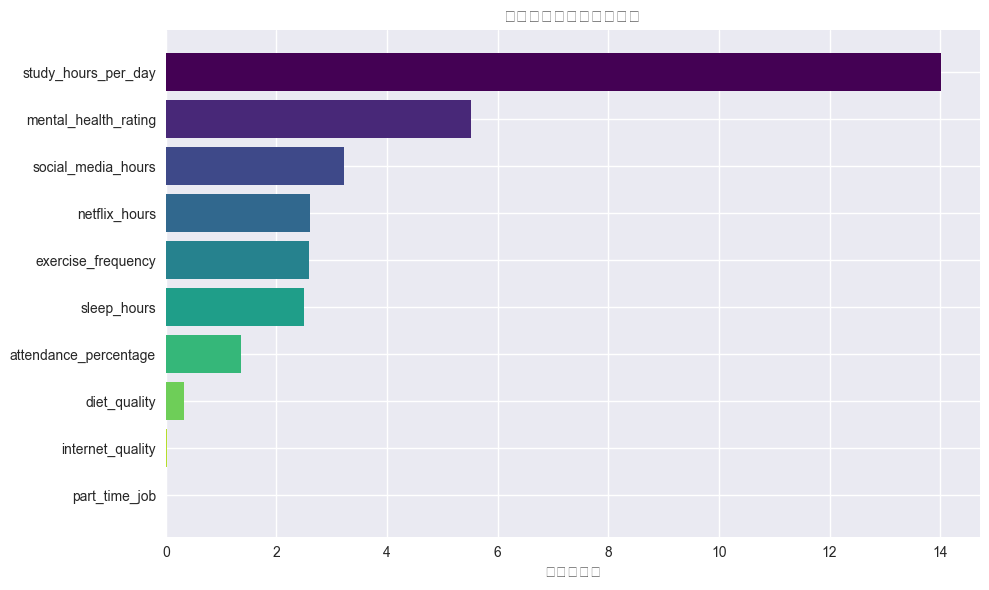

In [16]:
# 建立並訓練線性回歸模型
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# 顯示模型係數
print("模型截距:", lr_model.intercept_)
print("\n模型係數（特徵重要性）:")
coefficients = pd.DataFrame({
    '特徵': X_train_scaled.columns,
    '係數': lr_model.coef_
}).sort_values('係數', key=abs, ascending=False)
print(coefficients)

# 視覺化特徵重要性
plt.figure(figsize=(10, 6))
plt.barh(range(len(coefficients)), coefficients['係數'].abs(), 
         color=plt.cm.viridis(np.linspace(0, 1, len(coefficients))))
plt.yticks(range(len(coefficients)), coefficients['特徵'])
plt.xlabel('係數絕對值')
plt.title('線性回歸模型特徵重要性')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### 4.2 模型預測


In [17]:
# 進行預測
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

print("預測完成")
print(f"訓練集預測樣本數: {len(y_train_pred)}")
print(f"測試集預測樣本數: {len(y_test_pred)}")


預測完成
訓練集預測樣本數: 700
測試集預測樣本數: 300


## 5. 評估 (Evaluation)

### 5.1 計算評估指標


In [18]:
# 計算評估指標
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# 顯示評估結果
print("=" * 50)
print("模型評估指標")
print("=" * 50)
print(f"\n訓練集:")
print(f"  R² 分數: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE: {train_mae:.4f}")

print(f"\n測試集:")
print(f"  R² 分數: {test_r2:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")

# 建立評估結果表格
evaluation_results = pd.DataFrame({
    '指標': ['R² 分數', 'RMSE', 'MAE'],
    '訓練集': [train_r2, train_rmse, train_mae],
    '測試集': [test_r2, test_rmse, test_mae]
})

print("\n評估結果表格:")
print(evaluation_results.to_string(index=False))


模型評估指標

訓練集:
  R² 分數: 0.9013
  RMSE: 5.3291
  MAE: 4.2043

測試集:
  R² 分數: 0.8982
  RMSE: 5.3179
  MAE: 4.2429

評估結果表格:
   指標      訓練集      測試集
R² 分數 0.901307 0.898184
 RMSE 5.329126 5.317941
  MAE 4.204289 4.242887


### 5.2 視覺化評估結果


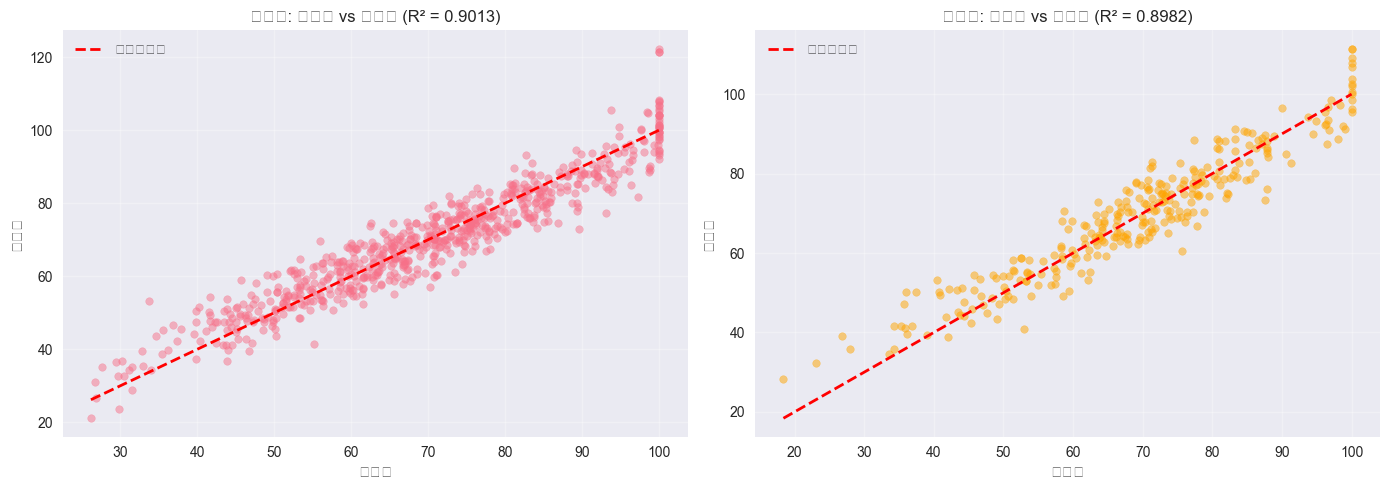

In [19]:
# 實際值 vs 預測值散點圖
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 訓練集
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=30)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='完美預測線')
axes[0].set_xlabel('實際值')
axes[0].set_ylabel('預測值')
axes[0].set_title(f'訓練集: 實際值 vs 預測值 (R² = {train_r2:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 測試集
axes[1].scatter(y_test, y_test_pred, alpha=0.5, s=30, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='完美預測線')
axes[1].set_xlabel('實際值')
axes[1].set_ylabel('預測值')
axes[1].set_title(f'測試集: 實際值 vs 預測值 (R² = {test_r2:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


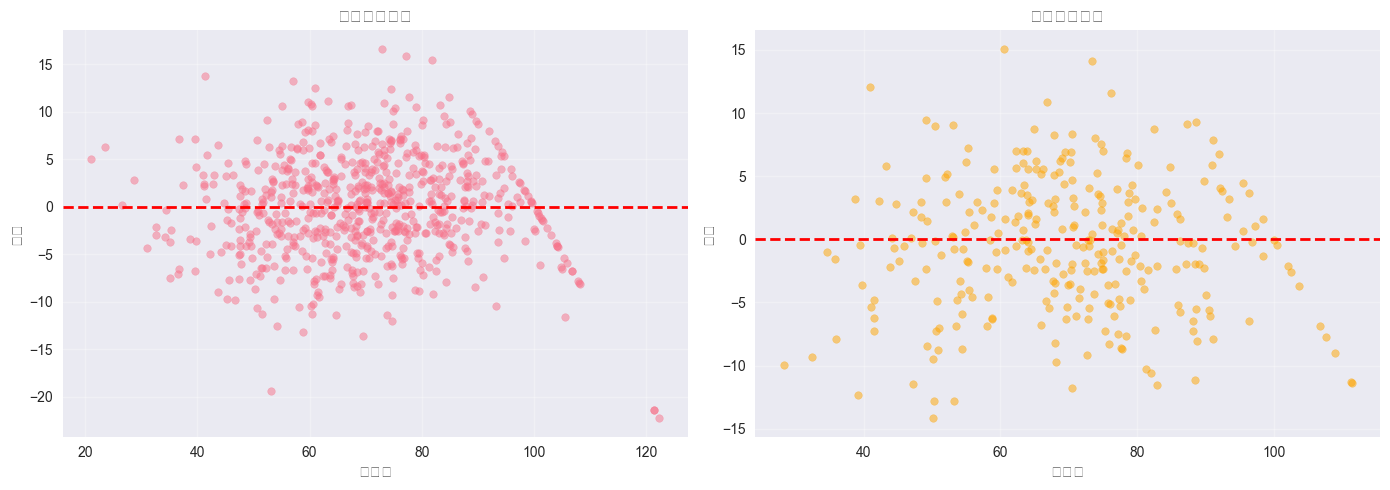

In [20]:
# 殘差分析
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 訓練集殘差
train_residuals = y_train - y_train_pred
axes[0].scatter(y_train_pred, train_residuals, alpha=0.5, s=30)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('預測值')
axes[0].set_ylabel('殘差')
axes[0].set_title('訓練集殘差圖')
axes[0].grid(True, alpha=0.3)

# 測試集殘差
test_residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, test_residuals, alpha=0.5, s=30, color='orange')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('預測值')
axes[1].set_ylabel('殘差')
axes[1].set_title('測試集殘差圖')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


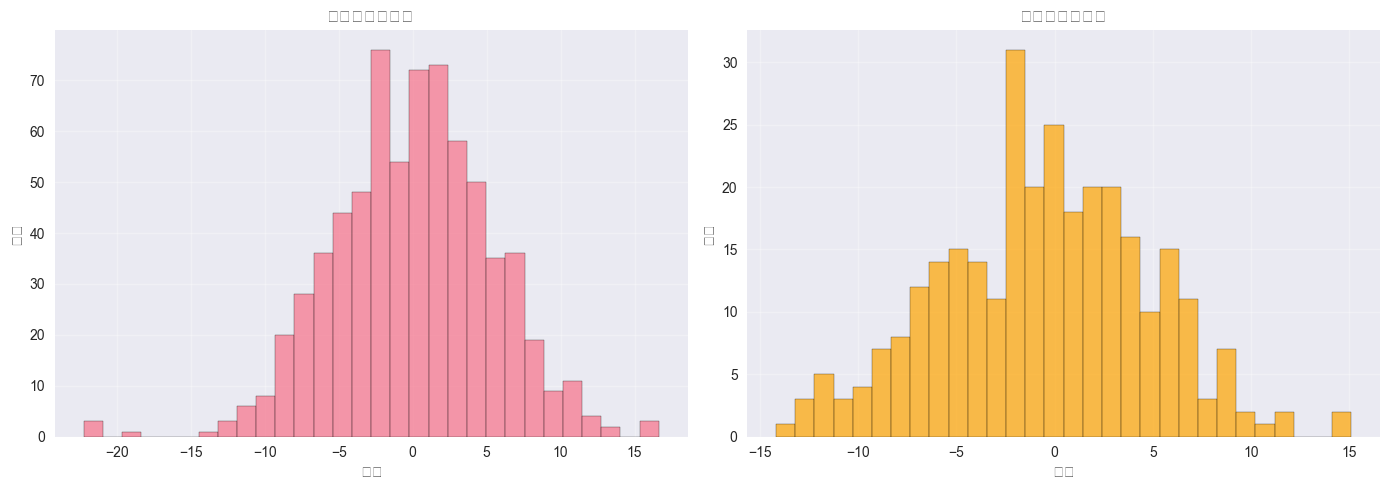

In [21]:
# 殘差分佈圖
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 訓練集殘差分佈
axes[0].hist(train_residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('殘差')
axes[0].set_ylabel('頻率')
axes[0].set_title('訓練集殘差分佈')
axes[0].grid(True, alpha=0.3)

# 測試集殘差分佈
axes[1].hist(test_residuals, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('殘差')
axes[1].set_ylabel('頻率')
axes[1].set_title('測試集殘差分佈')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 5.3 模型解釋性分析


In [22]:
# 分析模型係數的意義
print("=" * 50)
print("模型係數解釋")
print("=" * 50)
print("\n特徵係數（標準化後）:")
coefficients_sorted = coefficients.sort_values('係數', key=abs, ascending=False)
for idx, row in coefficients_sorted.iterrows():
    direction = "正向影響" if row['係數'] > 0 else "負向影響"
    print(f"  {row['特徵']}: {row['係數']:.4f} ({direction})")

print("\n主要發現:")
print("  1. 係數為正表示該特徵增加時，考試成績會提高")
print("  2. 係數為負表示該特徵增加時，考試成績會降低")
print("  3. 係數絕對值越大，表示影響程度越大")


模型係數解釋

特徵係數（標準化後）:
  study_hours_per_day: 14.0198 (正向影響)
  mental_health_rating: 5.5263 (正向影響)
  social_media_hours: -3.2246 (負向影響)
  netflix_hours: -2.6122 (負向影響)
  exercise_frequency: 2.5815 (正向影響)
  sleep_hours: 2.5014 (正向影響)
  attendance_percentage: 1.3636 (正向影響)
  diet_quality: -0.3348 (負向影響)
  internet_quality: -0.0267 (負向影響)
  part_time_job: -0.0071 (負向影響)

主要發現:
  1. 係數為正表示該特徵增加時，考試成績會提高
  2. 係數為負表示該特徵增加時，考試成績會降低
  3. 係數絕對值越大，表示影響程度越大


## 6. 總結與結論

### 模型表現總結
- **R² 分數**: 反映模型解釋變異的比例
- **RMSE**: 預測誤差的標準差，單位與目標變數相同
- **MAE**: 平均絕對誤差，更直觀的誤差指標

### 主要發現
1. **重要特徵**: 透過特徵選擇識別出影響學生表現的關鍵因素
2. **模型準確性**: 測試集 R² 分數反映模型的預測能力
3. **模型穩定性**: 訓練集和測試集表現相近，表示模型無過度擬合

### 後續建議
1. 可以嘗試其他模型（如隨機森林、XGBoost）進行比較
2. 進行更詳細的特徵工程（如特徵交互）
3. 考慮使用交叉驗證來更穩健地評估模型
4. 根據模型結果提出改善學生表現的具體建議

